# 3 Visualization and export of data

To run mayavi in jupyter notebook, we'll need to run: 

In [ ]:
%gui qt

In [2]:
import sys
sys.path.append('..')

from agrid.agrid import *

import agrid.accessories as grid_acc

/Users/tobiasstal/anaconda3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/tobiasstal/anaconda3/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


We stick to the same Antarctic example as before: 

In [ ]:
ant = Grid(crs=3031, res = [10*km, 10*km], 
           left = -3100*km, up=3100*km, right = 3100*km, down = -3100*km, 
           set_frame = False)

We download and extract some data: 

In [ ]:
grid_acc.download('http://www.seismolab.org/model/antarctica/lithosphere/AN1-HF.tar.gz', 
                  '../local/data/an/AN1-HF.tar.gz')


grid_acc.download('http://www.seismolab.org/model/antarctica/lithosphere/AN1-S_depth_grd.tar.gz', 
                  '../local/data/an/AN1-S/AN1-S_depth_grd.tar.gz')

We can have a quick look: 

In [ ]:
grid_acc.quick_look_netcdf('../local/data/an/AN1-HF.grd')


Data with right number of dimensions can be imported directely: 

In [ ]:
ant.ds['HF'] = (('Y', 'X'), ant.read_grid('../local/data/an/AN1-HF.grd', xyz = ('lon','lat','z') )) #Default crs is epsg:4326

We got a 3D model in the shape of a number of GMT .grd files. They are essentially netCDF format, but need to be placed in a 3D fram. We hardcode this: 

In [ ]:
grid_acc.quick_look_netcdf('../local/data/an/AN1-S/AN1-S_hslice_035.0.grd')

We make a list of files and associate depths from filenames: 

In [ ]:
import glob

an_files = sorted(glob.glob('../local/data/an/AN1-S/*.grd'))
#print(an_files)
ant.ds.coords['AN_Z'] = [np.float32(d[-9:-4])*km for d in an_files]
str_depths = [str(d[-9:-4]) for d in an_files]

print(ant.ds.coords['AN_Z'])

an_array = np.empty((ant.nx, ant.ny, len(an_files)))
an_array[:] = np.nan
for i, a in enumerate(ant.ds.coords['AN_Z'].values):
    print(a//km, end=', ')
    fname = '../local/data/an/AN1-S/AN1-S_hslice_%s.grd'%str_depths[i]
    if os.path.isfile(fname):
        an_array[:,:,i] = ant.read_grid(fname, xyz = ('x','y','z') ) 
    
ant.ds['AN_S'] = (('Y', 'X', 'AN_Z'), an_array)



This might be a good time to save the grid: 

In [3]:
! mkdir ../local/grids/ -p
import pickle
#pickle.dump(ant, open('../local/grids/ant.p', "wb" ))

#ant = None

#Or load: 
ant = pickle.load( open('../local/grids/ant.p', "rb" ) )

mkdir: ../local/grids/: File exists
mkdir: -p: File exists


We have already seen some option to look at the data. 

Me can store a map view as a map, with some funky features: 


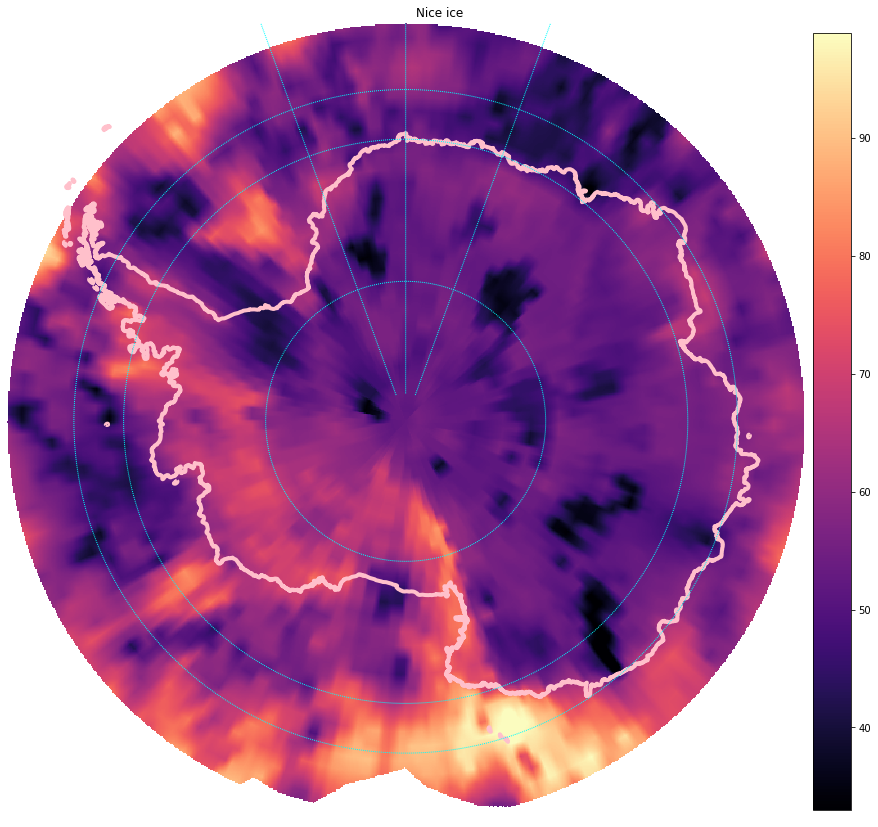

In [4]:
ant.map_grid('HF', cmap='magma', cbar=True, title='Nice ice', 
             par=[-66.563, -70, -80], mer = [-20, 0, 20], 
            line_c = 'pink', line_grid_c = 'cyan', line_w=4, 
            circ_map=True, )

Some basic 3D viz: 


In [ ]:
ant.oblique_view('HF', 
    save_name = '../local/grids/oblique.png',
    vmin= 30, vmax=100, 
    cmap='magma',
    warp_scale=2, 
    distance=1300,
    azimuth=180,
    roll=-90)

#! open oblique.png

We ran `%gui qt` and hince we can call mayavi to display the figure from Jupyter Notebook. Scene opens in new window. (Warning: This is not always so smooth with Jupyter.)

In [ ]:
ant.oblique_view('HF', 
    show_oblique=True,
    vmin= 30, vmax=100, 
    cmap='magma',
    warp_scale=2, 
    distance=1300,
    azimuth=180,
    roll=-90)

We try Bokeh for an interactive app that can be inbedded in e.g. Jupyter Notebook: 


In [5]:
ant.slider('AN_S')